<a href="https://colab.research.google.com/github/afvallejo/EgdeR/blob/main/Copy_of_EdgeR_GeneSymbol_single.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Overview
This notebook demonstrates an RNA-seq analysis workflow using the edgeR package.
Steps include installing required R packages, loading kallisto quantification results, merging sample metadata, quality control, normalization, and differential expression with limma-voom.
Code cells are executed with the %%R magic to run R within the Python environment.

## link Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [ ]:
%%capture
!pip install rpy2==3.5.1 plotnine mizani

In [ ]:
%load_ext rpy2.ipython

Search the internet for the desired packages, in CRAN and in Bioconducter. Return error messages and continue searching if not available

In [ ]:
# @title Install packages
%%capture
%%R
# Load necessary libraries
library(parallel)

# Function to check if a package is available on CRAN
is_available_cran <- function(pkg){
  r <- getOption("repos")
  r["CRAN"] <- "http://cran.us.r-project.org"
  available_pkgs <- available.packages(contriburl = contrib.url(r))
  pkg %in% rownames(available_pkgs)
}

# Function to check if a package is available on Bioconductor
is_available_bioc <- function(pkg){
  if("BiocManager" %in% rownames(installed.packages())) {
    available_pkgs <- BiocManager::available()
    pkg %in% available_pkgs
  } else {
    FALSE
  }
}

# Function to install GitHub package
install_github_package <- function(pkg, repo){
  if(!(pkg %in% rownames(installed.packages()))){
    if("devtools" %in% rownames(installed.packages())){
      suppressMessages(devtools::install_github(repo))
    } else {
      stop("devtools is not installed. Please install it before installing GitHub packages.")
    }
  }
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}

# Function to install packages
install_packages <- function(packages, Ncpus = detectCores()){
  for(pkg in packages){
    if(!(pkg %in% rownames(installed.packages()))){
      if(is_available_cran(pkg)){
        suppressMessages(install.packages(pkg, repos = "http://cran.us.r-project.org", Ncpus = Ncpus, ask = FALSE, quietly = TRUE))
      } else if(is_available_bioc(pkg)){
        if("BiocManager" %in% rownames(installed.packages())) {
          suppressMessages(BiocManager::install(pkg, Ncpus = Ncpus, ask = FALSE, quietly = TRUE))
        } else {
          stop("BiocManager is not installed. Please install it before installing Bioconductor packages.")
        }
      } else {
        stop(paste("Package", pkg, "is not available on CRAN or Bioconductor."))
      }
    }
    suppressPackageStartupMessages(library(pkg, character.only = TRUE))
  }
}

# Packages to install
packages <- c('devtools', 'tidyverse','BiocManager', 'dplyr', 'tidyverse', 'edgeR', 'limma',
              'tximport', 'biomaRt', 'genefilter', 'ensembldb', 'EnsDb.Hsapiens.v86',
              'EnsDb.Mmusculus.v79', 'rhdf5','RColorBrewer','vioplot','gplots','ggrepel','rtracklayer','FactoMineR','factoextra')

# Install and load packages
tryCatch({
  install_packages(packages)
  install_github_package("sleuth", "pachterlab/sleuth")
}, error = function(e) {
  message("Error in installing packages: ", e)
})


The following code installs any missing R packages from CRAN, Bioconductor or GitHub and then loads them for use in later steps.

In [ ]:
# @title check installed versions
%%R
sessionInfo()

## **Restart runtime**

In [ ]:
%cd /content/
%load_ext rpy2.ipython

[Errno 2] No such file or directory: '/content/'
/Users/andresvallejo
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
# @title Re-Load Packages
%%R
options(warn=-1)
# Packages to install
packages <- c('devtools', 'tidyverse','BiocManager', 'dplyr', 'tidyverse', 'edgeR', 'limma',
              'tximport', 'biomaRt', 'genefilter', 'ensembldb', 'EnsDb.Hsapiens.v86',
              'EnsDb.Mmusculus.v79', 'rhdf5', 'RColorBrewer', 'vioplot', 'gplots', 'ggrepel','rtracklayer','ggplot2','scales','FactoMineR','factoextra')

# Check if packages are installed; install them if they are not
for (pkg in packages) {
  if (!require(pkg, character.only = TRUE)) {
    if (pkg == 'BiocManager') {
      install.packages('BiocManager')
    }
    BiocManager::install(pkg)
  }
}

# Load the packages
for (pkg in packages) {
  library(pkg, character.only = TRUE)
}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: devtools
Loading required package: usethis
Loading required package: tidyverse
Loading required package: BiocManager
Bioconductor version 3.17 (BiocManager 1.30.23), R 4.3.0 (2023-04-21)
Bioconductor version '3.17' is out-of-date; the current release version '3.20'
  is available with R version '4.4'; see https://bioconductor.org/install

Attaching package: ‘BiocManager’

The following object is masked from ‘package:devtools’:

    install

Loading required package: edgeR
Loading required package: limma
Loading required package: tximport
Loading required package: biomaRt
Loading required package: genefilter

Attaching package: ‘genefilter’

The following object is masked from ‘package:readr’:

    spec

Loading required package: ensembldb
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, 

In [ ]:
%cd /Users/andresvallejo/Documents/00_Collaborations/Catherine/Neutrophils/Pseudobulk/scvi/

/Users/andresvallejo/Documents/00_Collaborations/Catherine/Neutrophils/Pseudobulk/scvi


In [ ]:
%%R
# User input for choosing the identifier type
identifier_type <- "gene_name" # User can change this to "gene_name" for gene symbol or "gene_id" for ensemble

sample_identifier <- "sample"

contrast_column <- "group"

# Specify the directory path
#aligned_dir <- "/content/drive/MyDrive/00_Colaborations/Catherine/Bulk/Doxy/Alingment/"

# Set the working directory
#setwd(aligned_dir)

root <- "single_TMM_FDR0.05"


##Load GTF file for gene name annotation

In [ ]:
%%R
options(warn=-1)
# URL of the GTF file to download
file_url <- 'https://ftp.ensembl.org/pub/release-109/gtf/homo_sapiens/Homo_sapiens.GRCh38.109.gtf.gz'

# Define the path where the file should be saved
gtf_file_path <- '/content/drive/MyDrive/tools/Homo_sapiens.GRCh38.113.concatenated.gtf.gz'
# Check if the file does not exist
if (!file.exists(gtf_file_path)) {
  message("File not found, downloading...")
  download.file(file_url, destfile = gtf_file_path, mode = "wb",method = "wget")
}

gtf_content <- import(gtf_file_path, feature.type = 'gene')
# Now, reading the first 10 lines of the file to check its content
cat(readLines(gtf_file_path, n = 10), sep = "\n")


In [ ]:
%%R

#gtf_content <- import(gtf_file_path, feature.type = 'gene')
annotation <- data.frame(elementMetadata(gtf_content), stringsAsFactors = FALSE)
row.names(annotation) <- annotation$gene_id

# Different parts based on the user input
annotation_transcript <- elementMetadata(import(gtf_file_path, feature.type = 'transcript'))

if (identifier_type == "gene_name") {
  # First chunk: Use gene_id and gene_name
  tx2gene <- annotation_transcript[,c("transcript_id","gene_name")]
  tx2gene <- dplyr::rename(as.data.frame(tx2gene), target_id = transcript_id, ext_gene = gene_name)
} else if (identifier_type == "gene_id") {
  # Second chunk: Use transcript_id and gene_name
  tx2gene <- annotation_transcript[,c("transcript_id","gene_id")]
  tx2gene <- dplyr::rename(as.data.frame(tx2gene), target_id = transcript_id, ext_gene = gene_id)
}

# Handling NA values in ext_gene column
tx2gene$ext_gene[is.na(tx2gene$ext_gene)] <- "NA"
# Removing rows with NA in any column
tx2gene <- na.omit(tx2gene)

# Printing the dimensions and the head of the final tx2gene object
print(dim(tx2gene))
print(head(tx2gene))

In [ ]:
%%R
setwd("/content/drive/MyDrive/00_Data/IBD_Bulk/results/")
# Get the names of all directories in the current working directory
directories <- list.dirs(path = ".", recursive = FALSE)

# Remove the initial "./" from each directory name
sample_names <- sub("./", "", directories)

# Create the full path by appending "/abundance.h5" to each directory name
paths <- paste0(directories, "/abundance.tsv")

# Combine into a data frame
df <- tibble(sample = sample_names, path = paths)

# Check if files exist
df <- df %>% mutate(file_exists = file.exists(path))

# Count and print the number of files that do not exist
num_nonexistent_files <- sum(!df$file_exists)
print(paste("Number of non-existent files: ", num_nonexistent_files))

# Remove rows corresponding to non-existent files from the data frame
df <- dplyr::filter(df, file_exists)

In [ ]:
%%R
paths

In [ ]:
# remove duplicated folders
#!find . -type d -name '* (*)' -exec rm -r {} \;

In [ ]:
%%capture
%%R
options(warn=-1)
Txi_gene <- tximport(paths,
                     type = "kallisto",
                     tx2gene = tx2gene,
                     txOut = FALSE, #determines whether your data represented at transcript or gene level
                     countsFromAbundance = "lengthScaledTPM",
                     ignoreTxVersion = TRUE)



In [ ]:
%%R
TPM <- Txi_gene$abundance
Counts <- Txi_gene$counts
colnames(Counts)<-sample_names
colSums(Counts)

In [ ]:
%%R
sample_names

In [ ]:
# prompt: change the "sample_names" from 1-TXM86075_out to Sample_1-TXM86075. make the code universal for all the columns with this format.

%%R
# Assuming sample_names is a character vector with names like "1-TXM86075_out"
new_sample_names <- gsub("_out$", "", sample_names)
new_sample_names <- gsub("^([0-9]+)-", "Sample_\\1-", new_sample_names)
new_sample_names


In [ ]:
%%R
colnames(Counts)<-new_sample_names

In [ ]:
%%R
names(Txi_gene)

In [ ]:
%%R
Counts[1:5,1:5]

In [ ]:
%%R
# Convert Counts matrix to a data frame
Counts <- as.data.frame(Counts)

In [ ]:
%%R
write.csv(Counts,'/content/drive/MyDrive/00_Data/IBD_Bulk/EDA/All_Samples_Gene_Kallisto.csv')

In [ ]:
%%R
Counts <- read.csv("/Users/andresvallejo/Documents/00_Collaborations/Catherine/Neutrophils/Pseudobulk/scvi/0_pseudobulk_counts_add_annotated_scvi_leiden_k10.csv",
                   header = TRUE, # Keep header
                   row.names = NULL, # Do not assign row names initially
                   stringsAsFactors = FALSE,
                   na.strings = "") # treat empty strings as NA if applicable

# Check for missing values in the first column
if (any(is.na(Counts[,1]))) {
  print("Warning: Missing values found in the intended row names column. Replacing with sequential numbers.")
  Counts[,1] <- ifelse(is.na(Counts[,1]), seq_len(nrow(Counts)), Counts[,1]) #replace NAs with row numbers
}

# Set the first column as row names
rownames(Counts) <- Counts[,1]

# Remove the first column from the data frame if needed
Counts <- Counts[,-1]

In [ ]:
%%R
Counts[1:5,1:5]

        DMTB150 DMTB160 DMTB180 DMTB200 DMTB220
A3GALT2      58      20      24      60     107
AAAS         36      10       0      25      92
AACS         12       4       0      13      20
AAGAB        43      36      18      93      67
AAK1        148      63      29     120     238


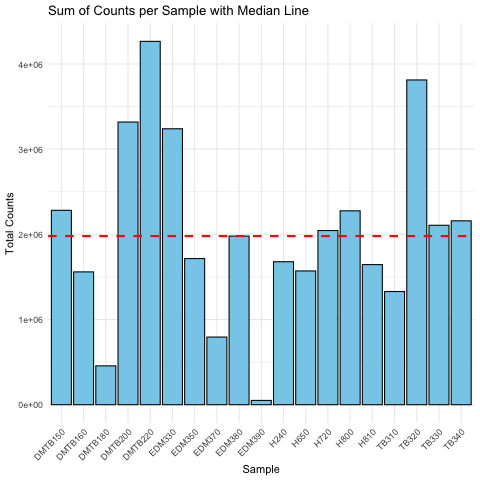

In [ ]:

%%R
# Load the ggplot2 packag

# Assuming 'Counts' is your matrix or data frame with count data
# Calculate column sums
countSums <- colSums(Counts)

# Convert to a data frame for ggplot2
countSumsDf <- data.frame(Sample = names(countSums), Count = countSums)

# Calculate the median count
medianCount <- median(countSums)

# Create the barplot with a horizontal line at the median and format y-axis labels
plot <- ggplot(countSumsDf, aes(x = Sample, y = Count)) +
  geom_bar(stat = "identity", fill = "skyblue", color = "black") +
  geom_hline(yintercept = medianCount, linetype = "dashed", color = "red", size = 1) +
  theme_minimal() +
  labs(title = "Sum of Counts per Sample with Median Line",
       x = "Sample",
       y = "Total Counts") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
 scale_y_continuous(labels = function(x) format(x, scientific = TRUE))  # Display labels in scientific notation

# Display the plot
print(plot)


# Save the plot as a PDF
ggsave("barplot_counts_median.pdf", plot = plot, device = "pdf", width = 10, height = 8)


# Load the Metadata

In [ ]:
#prepare a csv file of your metadata and read it here
%%R
metadata <- read.csv("/Users/andresvallejo/Documents/00_Collaborations/Catherine/Neutrophils/Pseudobulk/scvi/metadata.csv")
metadata[1:2,1:2]

   sample group
1 DMTB150  DMTB
2 DMTB160  DMTB


In [ ]:
%%R
# Rename a column named "old_column_name" to "sample_name"
colnames(metadata)[colnames(metadata) == sample_identifier] <- "sample_name"
colnames(metadata)[colnames(metadata) == contrast_column] <- "groupA"

metadata[1:2,1:2]

  sample_name groupA
1     DMTB150   DMTB
2     DMTB160   DMTB


# filter by the goups of interest

In [ ]:
%%R
metadata[1:2,1:2]

  sample_name groupA
1     DMTB150   DMTB
2     DMTB160   DMTB


In [ ]:
%%R
selected<-metadata[,'sample_name']
selected

 [1] "DMTB150" "DMTB160" "DMTB180" "DMTB200" "DMTB220" "EDM330"  "EDM350" 
 [8] "EDM370"  "EDM380"  "EDM390"  "H240"    "H650"    "H720"    "H800"   
[15] "H810"    "TB310"   "TB320"   "TB330"   "TB340"  


In [ ]:
%%R
# Check if the selected elements exist in the 'counts' DataFrame
existing_columns <- selected[selected %in% colnames(Counts)]

In [ ]:
%%R
existing_columns

 [1] "DMTB150" "DMTB160" "DMTB180" "DMTB200" "DMTB220" "EDM330"  "EDM350" 
 [8] "EDM370"  "EDM380"  "EDM390"  "H240"    "H650"    "H720"    "H800"   
[15] "H810"    "TB310"   "TB320"   "TB330"   "TB340"  


In [ ]:
%%R
counts2<- dplyr::select(Counts,all_of(existing_columns))
dim(counts2)

[1] 12541    19


In [ ]:
%%R
dim(metadata)

[1] 19  2


In [ ]:
%%R
# prompt: change this code for selecting rows instead of columns
# metadata1<- dplyr::select(metadata,all_of(existing_columns))
# dim(metadata1)

# Filter rows instead of columns
metadata <- metadata[metadata$sample_name %in% colnames(Counts), ]
dim(metadata)

[1] 19  2


# Metadata QC

In [ ]:
%%R
# Assuming 'Counts' is a matrix or dataframe with samples as columns
# and 'metadata' is a dataframe with a column 'sample_name' that matches the colnames of 'Counts'

# 1. Check if the number of samples matches
if(ncol(counts2) != nrow(metadata)) {
  stop("The number of samples in Counts does not match the number of entries in metadata.")
}

# 2. Reorder metadata to match the sample order in Counts
# This step assumes that 'sample_name' in metadata corresponds to the colnames in Counts
metadata_ordered <- metadata[match(colnames(counts2), metadata$sample_name), ]

# Check if the reordering was successful by comparing the order of 'sample_name' in metadata_ordered to colnames of Counts
if(!all(colnames(counts2) == metadata_ordered$sample_name)) {
  stop("Reordering failed: the sample order in metadata does not match the column names in Counts.")
} else {
  cat("QC passed: The samples in Counts and metadata are correctly ordered and match in size.\n")
}

# Now 'metadata_ordered' is ordered according to the 'Counts' samples and can be used for further analysis


QC passed: The samples in Counts and metadata are correctly ordered and match in size.


In [ ]:
%%R
metadata_ordered[1:2 ,1:2]

  sample_name groupA
1     DMTB150   DMTB
2     DMTB160   DMTB


Combining Metadata with Count Data

In [ ]:
%%R
stringsAsFactors = FALSE
sample <- factor(metadata_ordered$sample_name) #assign sample name from metadata
group <- factor(metadata_ordered$groupA) #assign disease group from metadata
print("group")
Condition<- factor(metadata_ordered$Condition)
col.cell <- brewer.pal(9,"Set1")[group] # assigns each group its own colour in future graphics
col.cell

[1] "group"
 [1] "#E41A1C" "#E41A1C" "#E41A1C" "#E41A1C" "#E41A1C" "#377EB8" "#377EB8"
 [8] "#377EB8" "#377EB8" "#377EB8" "#4DAF4A" "#4DAF4A" "#4DAF4A" "#4DAF4A"
[15] "#4DAF4A" "#984EA3" "#984EA3" "#984EA3" "#984EA3"


In [ ]:
%%R
Counts<-counts2

In [ ]:
%%R
write.csv(metadata_ordered,'/Users/andresvallejo/Documents/00_Collaborations/Catherine/Neutrophils/Pseudobulk/scvi/0_metadata_ordered_clean.csv')
write.csv(Counts,'/Users/andresvallejo/Documents/00_Collaborations/Catherine/Neutrophils/Pseudobulk/scvi/0_Counts_clean.csv')

In [ ]:
%%R
# Load necessary libraries
library(ggplot2)
library(ggpubr)

# Load the counts data (assuming counts is a data frame loaded previously)
# Replace 'Counts.csv' with the actual path if needed

# Specify the columns you want to correlate
column_x <- "S_361"  # Replace with the actual column name
target_column_y <- "S_381"  # Replace with the actual column name

# Perform correlation
correlation <- cor.test(Counts[[column_x]], Counts[[target_column_y]], method = "pearson")

# Extract R squared and p-value
r_squared <- correlation$estimate^2
p_value <- correlation$p.value

# Create correlation plot
correlation_plot <- ggplot(Counts, aes_string(x = column_x, y = target_column_y)) +
  geom_point(alpha = 0.6, color = "blue") +
  geom_smooth(method = "lm", se = TRUE, color = "red") +
  theme_minimal() +
  scale_x_log10() +
  scale_y_log10() +
  labs(title = paste("Correlation Plot of", column_x, "vs", target_column_y),
       subtitle = paste("R-squared =", round(r_squared, 3), "| p-value =", format.pval(p_value, digits = 3)),
       x = column_x,
       y = target_column_y)

# Display the plot
print(correlation_plot)

# Save the plot as a PDF
pdf("Correlation_Plot_S361.pdf")
print(correlation_plot)
dev.off()


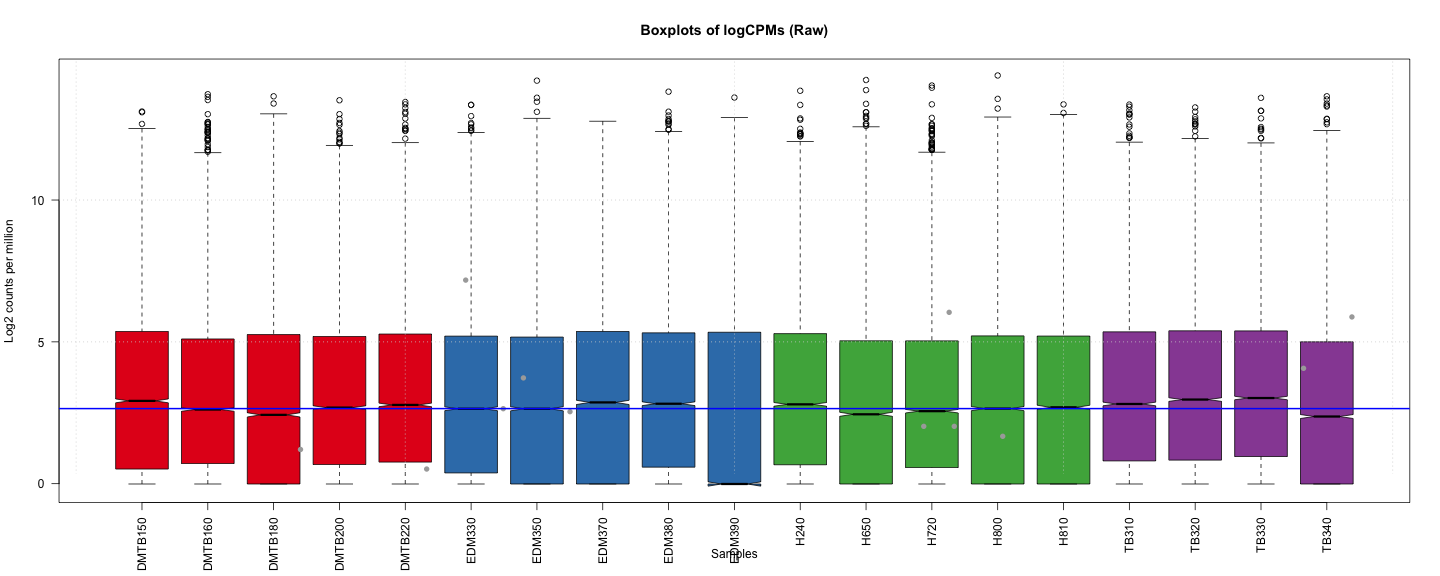

In [ ]:
# @title Box plot raw
%%R -w 20 -h 8 -u in

# Convert raw counts to logCPMs
logcounts1 <- cpm(Counts, log=TRUE)

# Save the plot as a PDF
pdf(file = "boxplot_logcounts1.pdf")
boxplot(logcounts1,
        xlab="Sample Groups",
        ylab="Log2 counts per million",
        las=2,
        col=col.cell,
        notch=TRUE,
        main="Boxplots of logCPMs")
par(cex.axis=0.5, las=1)
points(jitter(1:length(logcounts1)), logcounts1, col="darkgray", pch=16)
abline(h=median(logcounts1), col="blue", lwd=2)
grid(nx = NULL, ny = NULL, col = "lightgray", lty = "dotted")
dev.off() # Close the PDF device

# Display the same plot in the R environment
boxplot(logcounts1,
        xlab="Samples",
        ylab="Log2 counts per million",
        las=2,
        col=col.cell,
        notch=TRUE,
        main="Boxplots of logCPMs (Raw)")
par(mar=c(7, 4, 4, 2) + 0.1) # Adjusting margin for better visibility
points(jitter(1:length(logcounts1)), logcounts1, col="darkgray", pch=16)
abline(h=median(logcounts1), col="blue", lwd=2)
grid(nx = NULL, ny = NULL, col = "lightgray", lty = "dotted")


In [ ]:
%%R
raw_counts<-as.data.frame(Counts) # creating the raw_counts dataframe, separate from the log_cpm dataframe

In [ ]:
%%R
group # showing that samples are now grouped in 'group' by their disease group

 [1] DMTB DMTB DMTB DMTB DMTB EDM  EDM  EDM  EDM  EDM  HC   HC   HC   HC   HC  
[16] TB   TB   TB   TB  
Levels: DMTB EDM HC TB


Creating Matrix Model

In [ ]:
%%R
design <- model.matrix(~0+group) # assigning matrix model to the binary configuration (control vs test)

#design <- model.matrix(~donor+group) ---> this would instead seek to lay out matrix model to investigate donor effect on the different samples

#print(design)
colnames(design) # observing the generated matrix model

[1] "groupDMTB" "groupEDM"  "groupHC"   "groupTB"  


In [ ]:
%%R
dim(Counts)

[1] 12541    19


DGE analysis

In [ ]:
%%R
dge <- DGEList(counts= raw_counts,genes=row.names(raw_counts)) # produces a list of DEG using the dge() function
dge_norm <- calcNormFactors(dge,lib.size=T,method="TMM") # Uses TMM normalisation for the dge list
cpm.count <- cpm(dge_norm) # cacluating cpm for the normalised DGE data
keep <- filterByExpr(dge_norm,group=group) # edgeR fucntion that using compiting to automatically filter genes by expression level
dge_norm_filt<-dge_norm[keep,keep.lib.sizes=FALSE]
#keep = rowSums(cpm.count > as.numeric(2) ) >= as.numeric(3)
#dge_norm_filt <- dge_norm[keep,,keep.lib.sizes=FALSE] # -----> edgeR filtered analysis



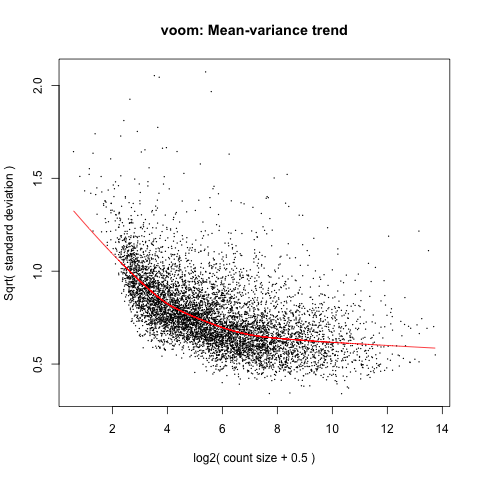

In [ ]:
%%R
#print(dim(dge_norm))
v <-  voom(dge_norm_filt, design=design, plot=TRUE) # produces a voom plot of DGE data, filtering out much of the background without affecting the normalisation of the group
#voom_dataframe <- as.data.frame(v)

Assessing normalisation of samples for outliers

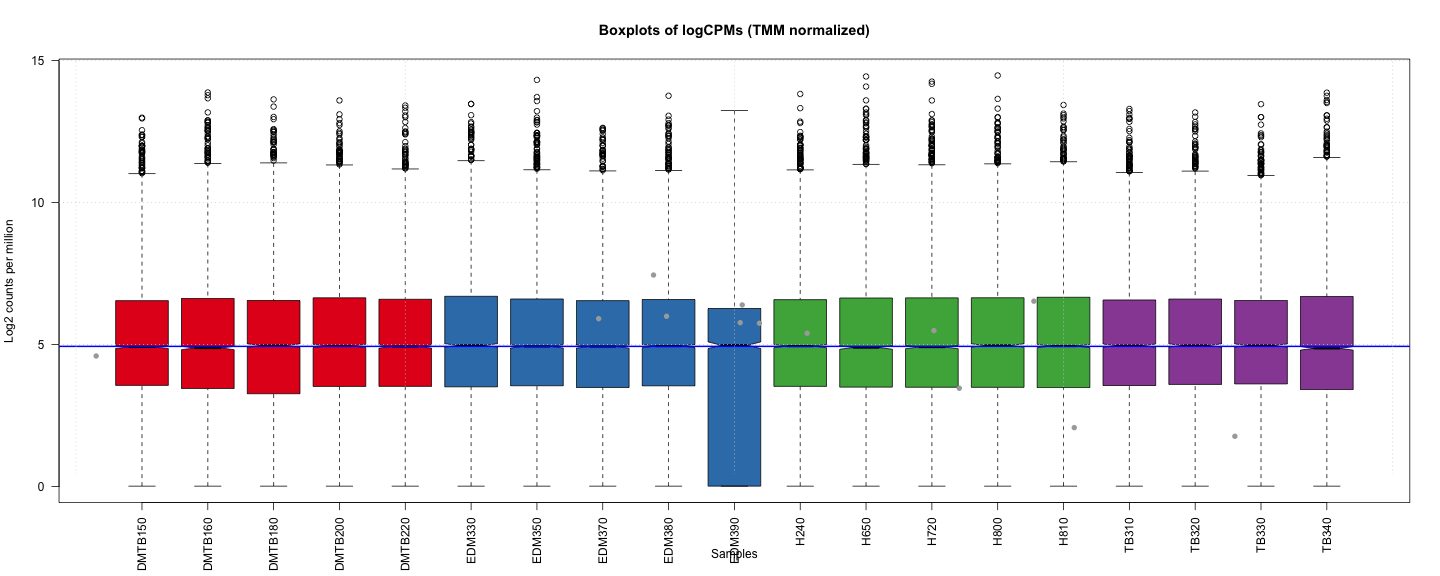

In [ ]:
# @title Box plot normalized
%%R -w 20 -h 8 -u in

# Convert raw counts to logCPMs
logcounts1 <- cpm(dge_norm_filt,log=TRUE)

# Save the plot as a PDF
pdf(file = "boxplot_logcounts1.pdf")
boxplot(logcounts1,
        xlab="Sample Groups",
        ylab="Log2 counts per million",
        las=2,
        col=col.cell,
        notch=TRUE,
        main="Boxplots of logCPMs")
par(cex.axis=0.5, las=1)
points(jitter(1:length(logcounts1)), logcounts1, col="darkgray", pch=16)
abline(h=median(logcounts1), col="blue", lwd=2)
grid(nx = NULL, ny = NULL, col = "lightgray", lty = "dotted")
dev.off() # Close the PDF device

# Display the same plot in the R environment
boxplot(logcounts1,
        xlab="Samples",
        ylab="Log2 counts per million",
        las=2,
        col=col.cell,
        notch=TRUE,
        main="Boxplots of logCPMs (TMM normalized)")
par(mar=c(7, 4, 4, 2) + 0.1) # Adjusting margin for better visibility
points(jitter(1:length(logcounts1)), logcounts1, col="darkgray", pch=16)
abline(h=median(logcounts1), col="blue", lwd=2)
grid(nx = NULL, ny = NULL, col = "lightgray", lty = "dotted")


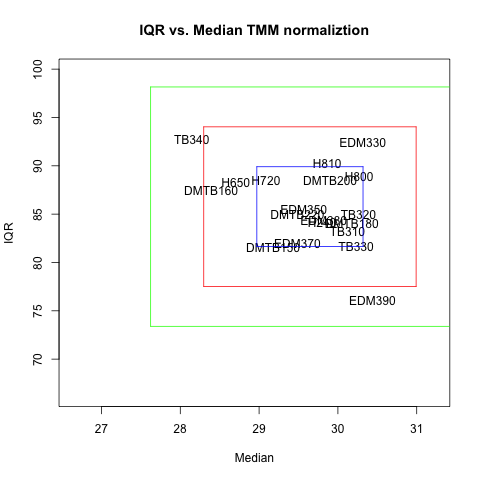

In [ ]:
# @title IQR plots
%%R

plot_name <- "SamplesIQRvsMedian"
file_name <- paste0(root, "_", plot_name, ".pdf")

pdf(file_name)
#  Make IQR_Median Plots
counts_filtered <- dge_norm_filt$counts
log_counts<-log(counts_filtered+1)
CPM<-cpm(dge_norm_filt)

IQR<-apply(CPM, 2, IQR)
Median<-apply(CPM, 2, median)
diff1<-mean(Median)-min(Median)
diff2<-max(Median)-mean(Median)
diff3<-mean(IQR)-min(IQR)
diff4<-max(IQR)-mean(IQR)

#  These plot settings work for this data and may need to be adjusted for your own data.
Xlim=c(mean(Median)-2*diff1,mean(Median)+2*diff2)
Ylim=c(mean(IQR)-2*diff3,mean(IQR)+2*diff4)


plot(Median, IQR, main="IQR vs. Median TMM normaliztion", type="n", xlim=Xlim,ylim=Ylim)
text(Median, IQR, labels=names(IQR))

#  Make boxes for StDev.
Median_mean<-mean(Median)
c_sd1_mean<-sd(Median)
c_sd2_mean<-2*sd(Median)
c_sd3_mean<-3*sd(Median)
IQR_mean<-mean(IQR)
c_sd1_IQR<-sd(IQR)
c_sd2_IQR<-2*sd(IQR)
c_sd3_IQR<-3*sd(IQR)

x0_c<-Median_mean-c_sd1_mean
y0_c<-IQR_mean-c_sd1_IQR
x1_c<-Median_mean+c_sd1_mean
y1_c<-IQR_mean+c_sd1_IQR

x0_c.2<-Median_mean-c_sd2_mean
y0_c.2<-IQR_mean-c_sd2_IQR
x1_c.2<-Median_mean+c_sd2_mean
y1_c.2<-IQR_mean+c_sd2_IQR

x0_c.3<-Median_mean-c_sd3_mean
y0_c.3<-IQR_mean-c_sd3_IQR
x1_c.3<-Median_mean+c_sd3_mean
y1_c.3<-IQR_mean+c_sd3_IQR

segments(x0_c,y0_c, x1=x1_c, y1=y0_c, col="blue")
segments(x0_c,y0_c, x1=x0_c, y1=y1_c, col="blue")
segments(x1_c,y0_c, x1=x1_c, y1=y1_c, col="blue")
segments(x0_c,y1_c, x1=x1_c, y1=y1_c, col="blue")

segments(x0_c.2,y0_c.2, x1=x1_c.2, y1=y0_c.2, col="red")
segments(x0_c.2,y0_c.2, x1=x0_c.2, y1=y1_c.2, col="red")
segments(x1_c.2,y0_c.2, x1=x1_c.2, y1=y1_c.2, col="red")
segments(x0_c.2,y1_c.2, x1=x1_c.2, y1=y1_c.2, col="red")

#  This portion is out of range so I removed it.
segments(x0_c.3,y0_c.3, x1=x1_c.3, y1=y0_c.3, col="green")
segments(x0_c.3,y0_c.3, x1=x0_c.3, y1=y1_c.3, col="green")
segments(x1_c.3,y0_c.3, x1=x1_c.3, y1=y1_c.3, col="green")
segments(x0_c.3,y1_c.3, x1=x1_c.3, y1=y1_c.3, col="green")

outliers2 <- which(IQR < IQR_mean - 2*sd(IQR) | IQR > IQR_mean + 2*sd(IQR))
points(Median[outliers2], IQR[outliers2], col="red", pch=19)

dev.off()


plot_name <- "SamplesIQRvsMedian"
file_name <- paste0(root, "_", plot_name, ".pdf")

#  Make IQR_Median Plots
counts_filtered <- dge_norm_filt$counts
log_counts<-log(counts_filtered+1)
CPM<-cpm(dge_norm_filt)

IQR<-apply(CPM, 2, IQR)
Median<-apply(CPM, 2, median)
diff1<-mean(Median)-min(Median)
diff2<-max(Median)-mean(Median)
diff3<-mean(IQR)-min(IQR)
diff4<-max(IQR)-mean(IQR)

#  These plot settings work for this data and may need to be adjusted for your own data.
Xlim=c(mean(Median)-2*diff1,mean(Median)+2*diff2)
Ylim=c(mean(IQR)-2*diff3,mean(IQR)+2*diff4)


plot(Median, IQR, main="IQR vs. Median TMM normaliztion", type="n", xlim=Xlim,ylim=Ylim)
text(Median, IQR, labels=names(IQR))

#  Make boxes for StDev.
Median_mean<-mean(Median)
c_sd1_mean<-sd(Median)
c_sd2_mean<-2*sd(Median)
c_sd3_mean<-3*sd(Median)
IQR_mean<-mean(IQR)
c_sd1_IQR<-sd(IQR)
c_sd2_IQR<-2*sd(IQR)
c_sd3_IQR<-3*sd(IQR)

x0_c<-Median_mean-c_sd1_mean
y0_c<-IQR_mean-c_sd1_IQR
x1_c<-Median_mean+c_sd1_mean
y1_c<-IQR_mean+c_sd1_IQR

x0_c.2<-Median_mean-c_sd2_mean
y0_c.2<-IQR_mean-c_sd2_IQR
x1_c.2<-Median_mean+c_sd2_mean
y1_c.2<-IQR_mean+c_sd2_IQR

x0_c.3<-Median_mean-c_sd3_mean
y0_c.3<-IQR_mean-c_sd3_IQR
x1_c.3<-Median_mean+c_sd3_mean
y1_c.3<-IQR_mean+c_sd3_IQR

segments(x0_c,y0_c, x1=x1_c, y1=y0_c, col="blue")
segments(x0_c,y0_c, x1=x0_c, y1=y1_c, col="blue")
segments(x1_c,y0_c, x1=x1_c, y1=y1_c, col="blue")
segments(x0_c,y1_c, x1=x1_c, y1=y1_c, col="blue")

segments(x0_c.2,y0_c.2, x1=x1_c.2, y1=y0_c.2, col="red")
segments(x0_c.2,y0_c.2, x1=x0_c.2, y1=y1_c.2, col="red")
segments(x1_c.2,y0_c.2, x1=x1_c.2, y1=y1_c.2, col="red")
segments(x0_c.2,y1_c.2, x1=x1_c.2, y1=y1_c.2, col="red")

#  This portion is out of range so I removed it.
segments(x0_c.3,y0_c.3, x1=x1_c.3, y1=y0_c.3, col="green")
segments(x0_c.3,y0_c.3, x1=x0_c.3, y1=y1_c.3, col="green")
segments(x1_c.3,y0_c.3, x1=x1_c.3, y1=y1_c.3, col="green")
segments(x0_c.3,y1_c.3, x1=x1_c.3, y1=y1_c.3, col="green")

outliers2 <- which(IQR < IQR_mean - 4*sd(IQR) | IQR > IQR_mean + 4*sd(IQR))
points(Median[outliers2], IQR[outliers2], col="red", pch=19)

In [ ]:
%%R
outliers2

named integer(0)


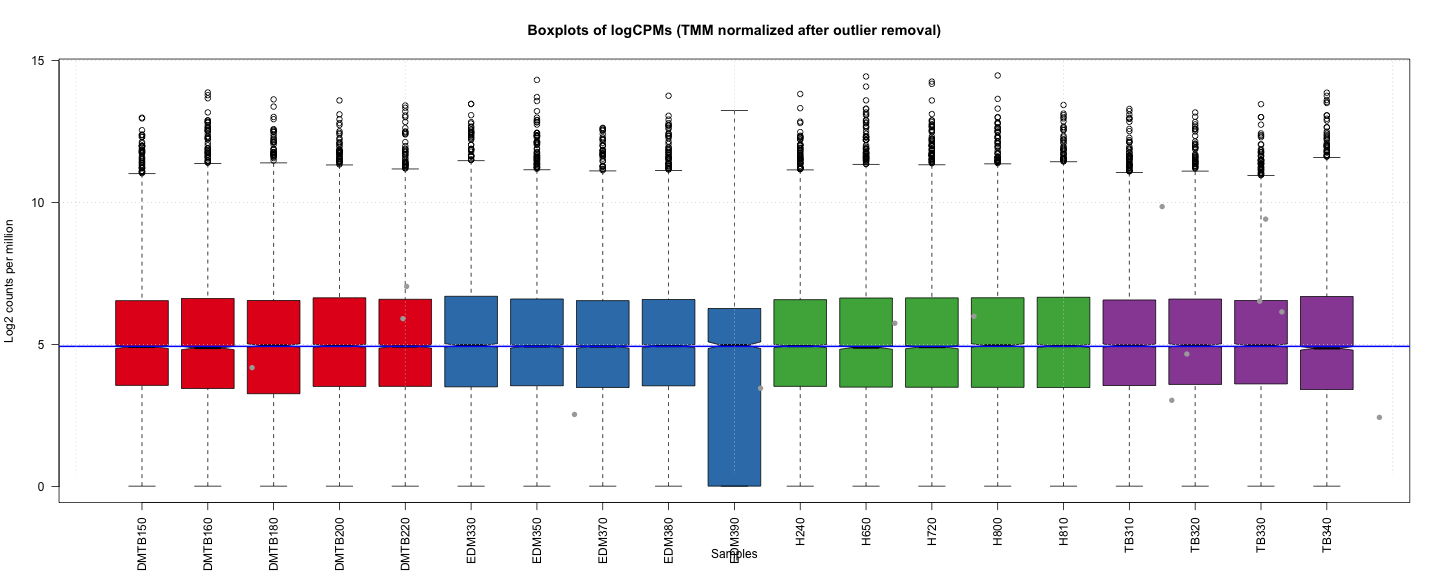

In [ ]:
%%R -w 20 -h 8 -u in

# Convert raw counts to logCPMs
logcounts1 <- cpm(dge_norm_filt,log=TRUE)

# Save the plot as a PDF
pdf(file = "boxplot_logcounts1.pdf")
boxplot(logcounts1,
        xlab="Sample Groups",
        ylab="Log2 counts per million",
        las=2,
        col=col.cell,
        notch=TRUE,
        main="Boxplots of logCPMs")
par(cex.axis=0.5, las=1)
points(jitter(1:length(logcounts1)), logcounts1, col="darkgray", pch=16)
abline(h=median(logcounts1), col="blue", lwd=2)
grid(nx = NULL, ny = NULL, col = "lightgray", lty = "dotted")
dev.off() # Close the PDF device

# Display the same plot in the R environment
boxplot(logcounts1,
        xlab="Samples",
        ylab="Log2 counts per million",
        las=2,
        col=col.cell,
        notch=TRUE,
        main="Boxplots of logCPMs (TMM normalized after outlier removal)")
par(mar=c(7, 4, 4, 2) + 0.1) # Adjusting margin for better visibility
points(jitter(1:length(logcounts1)), logcounts1, col="darkgray", pch=16)
abline(h=median(logcounts1), col="blue", lwd=2)
grid(nx = NULL, ny = NULL, col = "lightgray", lty = "dotted")

# PCA

In [ ]:
%%R

cpm<-cpm(dge_norm_filt)
#cpm<-cpm(v)

Y <- apply(cpm, 1, function(y) scale(y, center=TRUE, scale=FALSE))
s <- svd(Y)
#  Get Variance explained by the components
Var1<-s$d^2/sum(s$d^2)
Var2<-cumsum(s$d^2/sum(s$d^2))
Var<-cbind(Var1,Var2)
Var<-round(Var,3)
colnames(Var)<-c("Percent Variance","Cumulative % Variance")

In [ ]:
%%R
metadata

   sample_name groupA
1      DMTB150   DMTB
2      DMTB160   DMTB
3      DMTB180   DMTB
4      DMTB200   DMTB
5      DMTB220   DMTB
6       EDM330    EDM
7       EDM350    EDM
8       EDM370    EDM
9       EDM380    EDM
10      EDM390    EDM
11        H240     HC
12        H650     HC
13        H720     HC
14        H800     HC
15        H810     HC
16       TB310     TB
17       TB320     TB
18       TB330     TB
19       TB340     TB


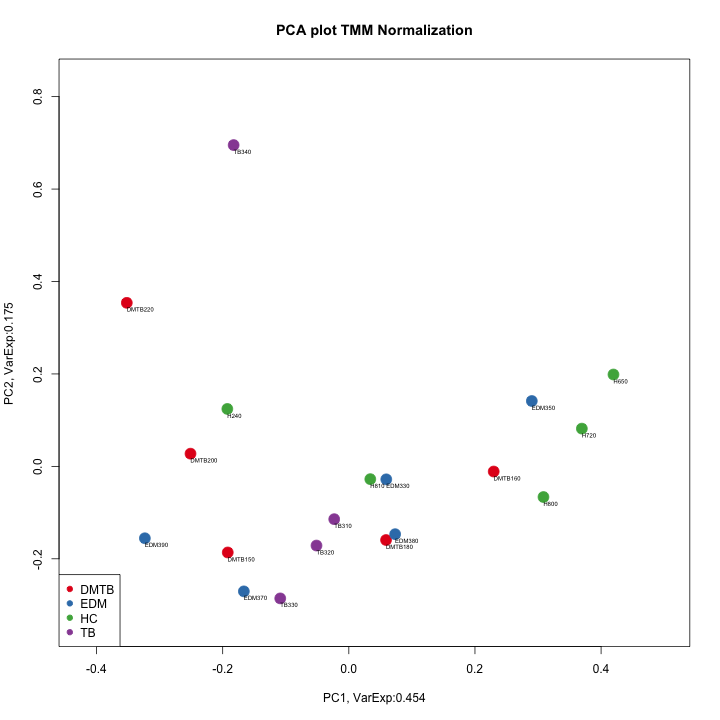

In [ ]:
%%R -w 10 -h 10 -u in

plot_name <- "PCA1"
file_name <- paste0(root, "_", plot_name, ".pdf")

pdf(file_name)
plot(s$u[,1], s$u[,2], pch=19, cex=2, xlab=paste0("PC1, VarExp:", round(Var[1],3)), ylab=paste0("PC2, VarExp:", round(Var[2],3)),main="PCA plot TMM Normalization",col=col.cell, ylim=c((min(s$u[,2])*1.2),(max(s$u[,2])*1.2)),xlim=c((min(s$u[,1])*1.2),(max(s$u[,1])*1.2)))
text(s$u[,1], s$u[,2], labels=colnames(CPM),adj=c(0,2),cex=0.5)
legend("bottomright",legend = unique(metadata$groupA),col = unique(col.cell), pch=19,cex=1)
dev.off()

plot(s$u[,1], s$u[,2], pch=19, cex=2, xlab=paste0("PC1, VarExp:", round(Var[1],3)), ylab=paste0("PC2, VarExp:", round(Var[2],3)),main="PCA plot TMM Normalization",col=col.cell, ylim=c((min(s$u[,2])*1.2),(max(s$u[,2])*1.2)),xlim=c((min(s$u[,1])*1.2),(max(s$u[,1])*1.2)))
text(s$u[,1], s$u[,2], labels=colnames(CPM),adj=c(0,2),cex=0.5)
legend("bottomleft",legend = unique(metadata$groupA),col = unique(col.cell), pch=19,cex=1)

In [ ]:
%%R
design

   groupDMTB groupEDM groupHC groupTB
1          1        0       0       0
2          1        0       0       0
3          1        0       0       0
4          1        0       0       0
5          1        0       0       0
6          0        1       0       0
7          0        1       0       0
8          0        1       0       0
9          0        1       0       0
10         0        1       0       0
11         0        0       1       0
12         0        0       1       0
13         0        0       1       0
14         0        0       1       0
15         0        0       1       0
16         0        0       0       1
17         0        0       0       1
18         0        0       0       1
19         0        0       0       1
attr(,"assign")
[1] 1 1 1 1
attr(,"contrasts")
attr(,"contrasts")$group
[1] "contr.treatment"



Designing new Matrix for DGE analysis

# EdgeR

In [ ]:
%%R
#dge_norm <- estimateGLMCommonDisp(dge_norm, design, verbose=TRUE)
#dge_norm<- estimateGLMTrendedDisp(dge_norm, design)
#dge_norm<- estimateGLMTagwiseDisp(dge_norm, design)
dge_norm_filt <- estimateDisp(dge_norm_filt, design, robust=TRUE)
fit <- glmFit(dge_norm_filt, design) # fitting the normalised DGE data, after calculating dispersion values

In [ ]:
%%R
colnames(design)

[1] "groupDMTB" "groupEDM"  "groupHC"   "groupTB"  


In [ ]:
%%R
root <- "DM_vs_DMTB"

In [ ]:
%%R
dge.lrt1 <- glmLRT(fit,contrast=c(1,-1,0,0))
#dge.lrt2 <- glmLRT(dge.fit,coef="groupC")
#dge.lrt3 <- glmLRT(dge.fit,contrast=c(0,0,0,0,1,-1))

#dge.lrt1 <- glmLRT(fit,contrast=c(1,-1)) # likelihood test, contrasting infected samples against healthy samples
#dge.lrt1 <- glmLRT(fit,contrast=c(0,0,1,-1)) # likelihood test, contrasting infected samples against healthy samples


In [ ]:
%%R

print(summary(decideTests(dge.lrt1))) # Showing summary of results, 635 significantly downregualted genes and 619 significantly upregulated genes


       1*groupDMTB -1*groupEDM
Down                        37
NotSig                    6978
Up                          33


In [ ]:
%%R
# Set the working directory
setwd("/Users/andresvallejo/Documents/00_Collaborations/Catherine/Neutrophils/Pseudobulk/scvi/")


In [ ]:
%%R
dge_norm <- estimateDisp(dge_norm, design, robust=TRUE)
dge_norm.fit <- glmFit(dge_norm, design) # fitting the normalised DGE data, after calculating dispersion values

# DM_vs_DMTB

In [ ]:
%%R
root <- "DM_vs_DMTB"

In [ ]:
# @title Filter expresion to max DEG
%%R






dge.lrt <- glmLRT(dge_norm.fit,contrast=c(1,-1,0,0))
#dge.lrt <- glmLRT(dge_norm.fit,contrast=c(1,-1,0,0)) # likelihood test, contrasting infected samples against healthy samples









reads.cpm <- cpm(dge_norm)
unfiltered.results <- data.frame(id=dge_norm$genes, reads.cpm, dge.lrt$table)

filter <- apply(X=reads.cpm, MARGIN=1,
                FUN=function(data) {data[order(rank(data), decreasing=TRUE)[2]]})


lowerQuantile <- mean(filter == 0)
if (lowerQuantile < .95) upperQuantile <- .95 else upperQuantile <- 1
theta <- seq(lowerQuantile, upperQuantile, length=50)

filtPadj <- filtered_p(filter=filter, test=unfiltered.results$PValue,
                       theta=theta, method="BH")

min.fdr <- 0.05
numRej <- colSums(filtPadj < min.fdr, na.rm = TRUE)

filter.quantiles <- quantile(filter, probs=theta)

lo.fit.theta <- lowess(numRej ~ theta, f=1/5)

if (max(numRej) <= 10) {
  j <- 1
} else {
  residual <- if (all(numRej==0)) {
    0
  } else {
    numRej[numRej > 0] - lo.fit.theta$y[numRej > 0]
  }
  thresh <- max(lo.fit.theta$y) - sqrt(mean(residual^2))
  j <- if (any(numRej > thresh)) {
    which(numRej > thresh)[1]
  } else {
    1
  }
}

results <- unfiltered.results
results$FDR <- filtPadj[, j, drop=TRUE]

results$de <- sign(results$logFC)*(results$FDR < 0.05)
results$sig <- abs(results$de)

results[is.na(results$sig),]$sig <- 0


In [ ]:
%%R
head(head(results[results$sig==1,]$genes))

[1] "ABCG1"   "AMZ2"    "ANAPC15" "AP4B1"   "ASTL"    "B3GNTL1"


In [ ]:
%%R -o results
file.name = paste(root, "results.csv", sep="_")
print(file.name)
#write.table(results, file=file.name, sep="\t", row.names=FALSE, quote=FALSE)
write.csv(results, file.name, row.names = FALSE)

[1] "DM_vs_DMTB_results.csv"


In [ ]:
%%R
print(dim(results[results$sig==1,]))
head(results[results$sig==1,])
edgeR_sig <- results[results$sig==1,]

csv_name <- "EdgeRDGE"
file_name <- paste0(root, "_", csv_name, ".csv")

write.csv(edgeR_sig, file_name, row.names = FALSE)

[1] 63 27


In [ ]:
%%R
# Subset upregulated genes
upregulated_genes_edgeR <- edgeR_sig[edgeR_sig$logFC > 0, ]

csv_name <- "EdgeRUpregulatedDGE"
file_name <- paste0(root, "_", csv_name, ".csv")

write.csv(upregulated_genes_edgeR, file_name, row.names = FALSE)

In [ ]:
%%R
# Subset downregulated genes
downregulated_genes_edgeR <- edgeR_sig[edgeR_sig$logFC < 0, ]

csv_name <- "EdgeRDownregulatedDGE"
file_name <- paste0(root, "_", csv_name, ".csv")

write.csv(downregulated_genes_edgeR, file_name, row.names = FALSE)

# HC_vs_TB

In [ ]:
%%R
colnames(design)

[1] "groupDMTB" "groupEDM"  "groupHC"   "groupTB"  


In [ ]:
%%R
root <- "HC_vs_TB"

In [ ]:
# @title Filter expresion to max DEG
%%R






dge.lrt <- glmLRT(dge_norm.fit,contrast=c(0,0,-1,1))
#dge.lrt <- glmLRT(dge_norm.fit,contrast=c(1,-1,0,0)) # likelihood test, contrasting infected samples against healthy samples









reads.cpm <- cpm(dge_norm)
unfiltered.results <- data.frame(id=dge_norm$genes, reads.cpm, dge.lrt$table)

filter <- apply(X=reads.cpm, MARGIN=1,
                FUN=function(data) {data[order(rank(data), decreasing=TRUE)[2]]})


lowerQuantile <- mean(filter == 0)
if (lowerQuantile < .95) upperQuantile <- .95 else upperQuantile <- 1
theta <- seq(lowerQuantile, upperQuantile, length=50)

filtPadj <- filtered_p(filter=filter, test=unfiltered.results$PValue,
                       theta=theta, method="BH")

min.fdr <- 0.05
numRej <- colSums(filtPadj < min.fdr, na.rm = TRUE)

filter.quantiles <- quantile(filter, probs=theta)

lo.fit.theta <- lowess(numRej ~ theta, f=1/5)

if (max(numRej) <= 10) {
  j <- 1
} else {
  residual <- if (all(numRej==0)) {
    0
  } else {
    numRej[numRej > 0] - lo.fit.theta$y[numRej > 0]
  }
  thresh <- max(lo.fit.theta$y) - sqrt(mean(residual^2))
  j <- if (any(numRej > thresh)) {
    which(numRej > thresh)[1]
  } else {
    1
  }
}

results <- unfiltered.results
results$FDR <- filtPadj[, j, drop=TRUE]

results$de <- sign(results$logFC)*(results$FDR < 0.05)
results$sig <- abs(results$de)

results[is.na(results$sig),]$sig <- 0


In [ ]:
%%R
head(head(results[results$sig==1,]$genes))

[1] "ASTL"    "BCL7B"   "CASS4"   "CCDC157" "CHCHD7"  "CLEC2B" 


In [ ]:
%%R -o results
file.name = paste(root, "results.csv", sep="_")
print(file.name)
#write.table(results, file=file.name, sep="\t", row.names=FALSE, quote=FALSE)
write.csv(results, file.name, row.names = FALSE)

[1] "HC_vs_TB_results.csv"


In [ ]:
%%R
print(dim(results[results$sig==1,]))
head(results[results$sig==1,])
edgeR_sig <- results[results$sig==1,]

csv_name <- "EdgeRDGE"
file_name <- paste0(root, "_", csv_name, ".csv")

write.csv(edgeR_sig, file_name, row.names = FALSE)

[1] 41 27


In [ ]:
%%R
# Subset upregulated genes
upregulated_genes_edgeR <- edgeR_sig[edgeR_sig$logFC > 0, ]

csv_name <- "EdgeRUpregulatedDGE"
file_name <- paste0(root, "_", csv_name, ".csv")

write.csv(upregulated_genes_edgeR, file_name, row.names = FALSE)

In [ ]:
%%R
# Subset downregulated genes
downregulated_genes_edgeR <- edgeR_sig[edgeR_sig$logFC < 0, ]

csv_name <- "EdgeRDownregulatedDGE"
file_name <- paste0(root, "_", csv_name, ".csv")

write.csv(downregulated_genes_edgeR, file_name, row.names = FALSE)

# HC_vs_DM

In [ ]:
%%R
colnames(design)

[1] "groupDMTB" "groupEDM"  "groupHC"   "groupTB"  


In [ ]:
%%R
root <- "HC_vs_DM"

In [ ]:
# @title Filter expresion to max DEG
%%R






dge.lrt <- glmLRT(dge_norm.fit,contrast=c(0,1,-1,0))
#dge.lrt <- glmLRT(dge_norm.fit,contrast=c(1,-1,0,0)) # likelihood test, contrasting infected samples against healthy samples









reads.cpm <- cpm(dge_norm)
unfiltered.results <- data.frame(id=dge_norm$genes, reads.cpm, dge.lrt$table)

filter <- apply(X=reads.cpm, MARGIN=1,
                FUN=function(data) {data[order(rank(data), decreasing=TRUE)[2]]})


lowerQuantile <- mean(filter == 0)
if (lowerQuantile < .95) upperQuantile <- .95 else upperQuantile <- 1
theta <- seq(lowerQuantile, upperQuantile, length=50)

filtPadj <- filtered_p(filter=filter, test=unfiltered.results$PValue,
                       theta=theta, method="BH")

min.fdr <- 0.05
numRej <- colSums(filtPadj < min.fdr, na.rm = TRUE)

filter.quantiles <- quantile(filter, probs=theta)

lo.fit.theta <- lowess(numRej ~ theta, f=1/5)

if (max(numRej) <= 10) {
  j <- 1
} else {
  residual <- if (all(numRej==0)) {
    0
  } else {
    numRej[numRej > 0] - lo.fit.theta$y[numRej > 0]
  }
  thresh <- max(lo.fit.theta$y) - sqrt(mean(residual^2))
  j <- if (any(numRej > thresh)) {
    which(numRej > thresh)[1]
  } else {
    1
  }
}

results <- unfiltered.results
results$FDR <- filtPadj[, j, drop=TRUE]

results$de <- sign(results$logFC)*(results$FDR < 0.05)
results$sig <- abs(results$de)

results[is.na(results$sig),]$sig <- 0


In [ ]:
%%R
head(head(results[results$sig==1,]$genes))

character(0)


In [ ]:
%%R -o results
file.name = paste(root, "results.csv", sep="_")
print(file.name)
#write.table(results, file=file.name, sep="\t", row.names=FALSE, quote=FALSE)
write.csv(results, file.name, row.names = FALSE)

[1] "HC_vs_DM_results.csv"


In [ ]:
%%R
print(dim(results[results$sig==1,]))
head(results[results$sig==1,])
edgeR_sig <- results[results$sig==1,]

csv_name <- "EdgeRDGE"
file_name <- paste0(root, "_", csv_name, ".csv")

write.csv(edgeR_sig, file_name, row.names = FALSE)

[1]  0 27


In [ ]:
%%R
# Subset upregulated genes
upregulated_genes_edgeR <- edgeR_sig[edgeR_sig$logFC > 0, ]

csv_name <- "EdgeRUpregulatedDGE"
file_name <- paste0(root, "_", csv_name, ".csv")

write.csv(upregulated_genes_edgeR, file_name, row.names = FALSE)

In [ ]:
%%R
# Subset downregulated genes
downregulated_genes_edgeR <- edgeR_sig[edgeR_sig$logFC < 0, ]

csv_name <- "EdgeRDownregulatedDGE"
file_name <- paste0(root, "_", csv_name, ".csv")

write.csv(downregulated_genes_edgeR, file_name, row.names = FALSE)

# TB_vs_DMTB

In [ ]:
%%R
colnames(design)

[1] "groupDMTB" "groupEDM"  "groupHC"   "groupTB"  


In [ ]:
%%R
root <- "TB_vs_DMTB"

In [ ]:
# @title Filter expresion to max DEG
%%R






dge.lrt <- glmLRT(dge_norm.fit,contrast=c(1,0,0,-1))
#dge.lrt <- glmLRT(dge_norm.fit,contrast=c(1,-1,0,0)) # likelihood test, contrasting infected samples against healthy samples









reads.cpm <- cpm(dge_norm)
unfiltered.results <- data.frame(id=dge_norm$genes, reads.cpm, dge.lrt$table)

filter <- apply(X=reads.cpm, MARGIN=1,
                FUN=function(data) {data[order(rank(data), decreasing=TRUE)[2]]})


lowerQuantile <- mean(filter == 0)
if (lowerQuantile < .95) upperQuantile <- .95 else upperQuantile <- 1
theta <- seq(lowerQuantile, upperQuantile, length=50)

filtPadj <- filtered_p(filter=filter, test=unfiltered.results$PValue,
                       theta=theta, method="BH")

min.fdr <- 0.05
numRej <- colSums(filtPadj < min.fdr, na.rm = TRUE)

filter.quantiles <- quantile(filter, probs=theta)

lo.fit.theta <- lowess(numRej ~ theta, f=1/5)

if (max(numRej) <= 10) {
  j <- 1
} else {
  residual <- if (all(numRej==0)) {
    0
  } else {
    numRej[numRej > 0] - lo.fit.theta$y[numRej > 0]
  }
  thresh <- max(lo.fit.theta$y) - sqrt(mean(residual^2))
  j <- if (any(numRej > thresh)) {
    which(numRej > thresh)[1]
  } else {
    1
  }
}

results <- unfiltered.results
results$FDR <- filtPadj[, j, drop=TRUE]

results$de <- sign(results$logFC)*(results$FDR < 0.05)
results$sig <- abs(results$de)

results[is.na(results$sig),]$sig <- 0


In [ ]:
%%R
head(head(results[results$sig==1,]$genes))

character(0)


In [ ]:
%%R -o results
file.name = paste(root, "results.csv", sep="_")
print(file.name)
#write.table(results, file=file.name, sep="\t", row.names=FALSE, quote=FALSE)
write.csv(results, file.name, row.names = FALSE)

[1] "TB_vs_DMTB_results.csv"


In [ ]:
%%R
print(dim(results[results$sig==1,]))
head(results[results$sig==1,])
edgeR_sig <- results[results$sig==1,]

csv_name <- "EdgeRDGE"
file_name <- paste0(root, "_", csv_name, ".csv")

write.csv(edgeR_sig, file_name, row.names = FALSE)

[1]  0 27


In [ ]:
%%R
# Subset upregulated genes
upregulated_genes_edgeR <- edgeR_sig[edgeR_sig$logFC > 0, ]

csv_name <- "EdgeRUpregulatedDGE"
file_name <- paste0(root, "_", csv_name, ".csv")

write.csv(upregulated_genes_edgeR, file_name, row.names = FALSE)

In [ ]:
%%R
# Subset downregulated genes
downregulated_genes_edgeR <- edgeR_sig[edgeR_sig$logFC < 0, ]

csv_name <- "EdgeRDownregulatedDGE"
file_name <- paste0(root, "_", csv_name, ".csv")

write.csv(downregulated_genes_edgeR, file_name, row.names = FALSE)

In [ ]:
%cd /Users/andresvallejo/Documents/00_Collaborations/Catherine/Neutrophils/Pseudobulk/scvi/Figures/

/Users/andresvallejo/Documents/00_Collaborations/Catherine/Neutrophils/Pseudobulk/scvi/Figures


In [ ]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_boxplot, geom_point, geom_line, theme_minimal, labs, scale_color_brewer, theme, element_text, position_dodge, position_jitterdodge, facet_wrap
import ipywidgets as widgets
from IPython.display import display
def load_data(path, sep=','):
    try:
        return pd.read_csv(path, sep=sep, engine='python')
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None


In [ ]:
# Update these paths as needed
metadata1_path = '/Users/andresvallejo/Documents/00_Collaborations/Catherine/Neutrophils/Pseudobulk/scvi/0_metadata_ordered_clean.csv'
results_path = '/Users/andresvallejo/Documents/00_Collaborations/Catherine/Neutrophils/Pseudobulk/scvi/HC_vs_TB_results.csv'

In [ ]:
metadata1 = load_data(metadata1_path)
results = load_data(results_path)

In [ ]:
metadata1 = metadata1.rename(columns={'sample_name': 'Sample'})

In [ ]:
metadata1

,Unnamed: 0,Sample,groupA
0,1,DMTB150,DMTB
1,2,DMTB160,DMTB
2,3,DMTB180,DMTB
3,4,DMTB200,DMTB
4,5,DMTB220,DMTB
5,6,EDM330,EDM
6,7,EDM350,EDM
7,8,EDM370,EDM
8,9,EDM380,EDM
9,10,EDM390,EDM


In [ ]:
# prompt: write code to add S_ to all the items in the column Sample of metadata1

# Assuming metadata1 is already loaded as a pandas DataFrame
if metadata1 is not None:
  metadata1['Sample'] = 'S_' + metadata1['Sample'].astype(str)
metadata1

,Unnamed: 0,Sample,groupA
0,1,S_DMTB150,DMTB
1,2,S_DMTB160,DMTB
2,3,S_DMTB180,DMTB
3,4,S_DMTB200,DMTB
4,5,S_DMTB220,DMTB
5,6,S_EDM330,EDM
6,7,S_EDM350,EDM
7,8,S_EDM370,EDM
8,9,S_EDM380,EDM
9,10,S_EDM390,EDM


In [ ]:
# prompt: order metadata1 by column groupA, use this order, HC, TB,EDM,DMTB

if metadata1 is not None:
  # Define the desired order for the 'groupA' column
  desired_order = ['HC', 'TB', 'EDM', 'DMTB']

  # Create a categorical dtype with the desired order
  metadata1['groupA'] = pd.Categorical(metadata1['groupA'], categories=desired_order, ordered=True)

  # Sort the DataFrame by the 'groupA' column
  metadata1 = metadata1.sort_values('groupA')

  # Display the sorted DataFrame (optional)
metadata1

,Unnamed: 0,Sample,groupA
14,15,S_H810,HC
13,14,S_H800,HC
12,13,S_H720,HC
11,12,S_H650,HC
10,11,S_H240,HC
18,19,S_TB340,TB
16,17,S_TB320,TB
15,16,S_TB310,TB
17,18,S_TB330,TB
9,10,S_EDM390,EDM


In [ ]:
results

,genes,S_DMTB150,S_DMTB160,S_DMTB180,S_DMTB200,S_DMTB220,S_EDM330,S_EDM350,S_EDM370,S_EDM380,...,S_TB320,S_TB330,S_TB340,logFC,logCPM,LR,PValue,FDR,de,sig
0,A3GALT2,23.049747,14.126350,51.581228,18.991307,24.312779,26.346763,7.515636,20.286423,28.455418,...,17.840743,18.433831,21.358390,-0.313881,4.488489,0.460845,0.497229,0.911619,0.0,0
1,AAAS,14.306740,7.063175,0.000000,7.913045,20.904445,9.004590,6.263030,18.032376,20.738694,...,16.374380,24.864238,14.950873,0.472512,3.777156,1.028949,0.310406,0.845795,0.0,0
2,AACS,4.768913,2.825270,0.000000,4.114783,4.544445,4.002040,2.505212,18.032376,4.822952,...,5.621056,6.430406,5.873557,0.274836,2.678879,0.292483,0.588633,0.936048,0.0,0
3,AAGAB,17.088606,25.427431,38.685921,29.436526,15.223890,25.346253,25.052121,30.429635,29.420008,...,22.484224,15.004281,36.309264,0.243354,4.693369,0.494490,0.481931,0.910753,0.0,0
4,AAK1,58.816596,44.498004,62.327317,37.982614,54.078891,34.350843,43.841212,61.986293,54.981655,...,64.275553,48.871088,62.473292,0.236813,5.766581,0.711186,0.399050,0.875716,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12536,ZXDB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.512857,0.045668,1.391911,0.238083,NaN,NaN,0
12537,ZXDC,102.531633,74.163340,60.178100,69.634792,153.829451,72.703726,68.267030,82.272716,67.521331,...,89.936895,61.303207,103.588193,0.080884,6.377659,0.071299,0.789454,0.979038,0.0,0
12538,ZYG11B,40.933171,27.546383,45.133575,40.514788,74.301670,39.353393,22.546909,43.953917,31.831485,...,38.125423,35.152888,69.414769,0.335760,5.493646,1.033592,0.309317,0.844122,0.0,0
12539,ZYX,1760.921189,2027.131286,1016.580039,1795.311539,1276.080054,2046.709931,2240.912248,1278.044653,1022.465866,...,959.734203,1106.887275,1413.925445,-0.546609,10.539339,3.356037,0.066959,0.579943,0.0,0


In [ ]:

import pandas as pd

def add_prefix_to_columns(df, prefix='S_'):
    # Columns to exclude from prefix addition
    exclude_cols = ['genes', 'logFC', 'logCPM', 'LR', 'PValue', 'FDR', 'de', 'sig']

    # Create new column names
    new_cols = []
    for col in df.columns:
        if col in exclude_cols:
            new_cols.append(col)
        else:
            new_cols.append(prefix + col)

    # Rename columns in DataFrame
    df.columns = new_cols
    return df


# Example usage (assuming 'results' DataFrame is already loaded)
# Replace 'results' with the actual name of your DataFrame if different
if 'results' in locals():
    results = add_prefix_to_columns(results)
    print(results.head()) #verify changes
else:
    print("Error: 'results' DataFrame not found. Please ensure it's loaded correctly.")

     genes  S_DMTB150  S_DMTB160  S_DMTB180  S_DMTB200  S_DMTB220   S_EDM330  \
0  A3GALT2  23.049747  14.126350  51.581228  18.991307  24.312779  26.346763   
1     AAAS  14.306740   7.063175   0.000000   7.913045  20.904445   9.004590   
2     AACS   4.768913   2.825270   0.000000   4.114783   4.544445   4.002040   
3    AAGAB  17.088606  25.427431  38.685921  29.436526  15.223890  25.346253   
4     AAK1  58.816596  44.498004  62.327317  37.982614  54.078891  34.350843   

    S_EDM350   S_EDM370   S_EDM380  ...    S_TB320    S_TB330    S_TB340  \
0   7.515636  20.286423  28.455418  ...  17.840743  18.433831  21.358390   
1   6.263030  18.032376  20.738694  ...  16.374380  24.864238  14.950873   
2   2.505212  18.032376   4.822952  ...   5.621056   6.430406   5.873557   
3  25.052121  30.429635  29.420008  ...  22.484224  15.004281  36.309264   
4  43.841212  61.986293  54.981655  ...  64.275553  48.871088  62.473292   

      logFC    logCPM        LR    PValue       FDR   de  sig 

In [ ]:
results

,genes,S_DMTB150,S_DMTB160,S_DMTB180,S_DMTB200,S_DMTB220,S_EDM330,S_EDM350,S_EDM370,S_EDM380,...,S_TB320,S_TB330,S_TB340,logFC,logCPM,LR,PValue,FDR,de,sig
0,A3GALT2,23.049747,14.126350,51.581228,18.991307,24.312779,26.346763,7.515636,20.286423,28.455418,...,17.840743,18.433831,21.358390,-0.313881,4.488489,0.460845,0.497229,0.911619,0.0,0
1,AAAS,14.306740,7.063175,0.000000,7.913045,20.904445,9.004590,6.263030,18.032376,20.738694,...,16.374380,24.864238,14.950873,0.472512,3.777156,1.028949,0.310406,0.845795,0.0,0
2,AACS,4.768913,2.825270,0.000000,4.114783,4.544445,4.002040,2.505212,18.032376,4.822952,...,5.621056,6.430406,5.873557,0.274836,2.678879,0.292483,0.588633,0.936048,0.0,0
3,AAGAB,17.088606,25.427431,38.685921,29.436526,15.223890,25.346253,25.052121,30.429635,29.420008,...,22.484224,15.004281,36.309264,0.243354,4.693369,0.494490,0.481931,0.910753,0.0,0
4,AAK1,58.816596,44.498004,62.327317,37.982614,54.078891,34.350843,43.841212,61.986293,54.981655,...,64.275553,48.871088,62.473292,0.236813,5.766581,0.711186,0.399050,0.875716,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12536,ZXDB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.512857,0.045668,1.391911,0.238083,NaN,NaN,0
12537,ZXDC,102.531633,74.163340,60.178100,69.634792,153.829451,72.703726,68.267030,82.272716,67.521331,...,89.936895,61.303207,103.588193,0.080884,6.377659,0.071299,0.789454,0.979038,0.0,0
12538,ZYG11B,40.933171,27.546383,45.133575,40.514788,74.301670,39.353393,22.546909,43.953917,31.831485,...,38.125423,35.152888,69.414769,0.335760,5.493646,1.033592,0.309317,0.844122,0.0,0
12539,ZYX,1760.921189,2027.131286,1016.580039,1795.311539,1276.080054,2046.709931,2240.912248,1278.044653,1022.465866,...,959.734203,1106.887275,1413.925445,-0.546609,10.539339,3.356037,0.066959,0.579943,0.0,0


In [ ]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_boxplot, geom_point, geom_line, theme_minimal, labs, scale_color_brewer, theme, element_text, position_dodge, position_jitterdodge, facet_wrap
import ipywidgets as widgets
from IPython.display import display

def load_data(path, sep=','):
    try:
        return pd.read_csv(path, sep=sep, engine='python')
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None





if metadata1 is not None and results is not None:
    significant_genes = results.query('sig == 1')['genes'].dropna()
    default_gene = np.random.choice(significant_genes.unique()) if not significant_genes.empty else None





def update_plot(selected_gene):
    try:
        # Corrected line for selecting columns based on multiple conditions
        column_filter = results.columns.str.startswith('S_') | results.columns.isin(['genes', 'logFC', 'sig'])
        resultsbox = results.loc[:, column_filter]

        tidy_results = pd.melt(resultsbox, id_vars=['genes', 'logFC', 'sig'], var_name='Sample_id', value_name='expression')
        tidy_results = pd.merge(tidy_results, metadata1, left_on='Sample_id', right_on='Sample', how='left')

        if selected_gene in significant_genes.values:
            is_sig = ' (significant)'
        else:
            is_sig = ''

        plot_title = f"Expression of {selected_gene}{is_sig}"
        plot = (ggplot(tidy_results[tidy_results['genes'] == selected_gene], aes(x='groupA', y='expression', fill='groupA')) +
                geom_boxplot(position=position_dodge(0.75), outlier_alpha=0) +
                geom_point(size=3, stroke=0.5, alpha=0.6, position=position_jitterdodge(jitter_width=0.2, dodge_width=0.75)) +
                #geom_line(aes(group='Donor', color='Donor'), alpha=0.5, size=1) +
                facet_wrap('~ genes', scales='free', ncol=3) +
                theme_minimal() +
                labs(title=plot_title, x='groupA', y='Expression') +
                theme(figure_size=(10, 6), axis_text_x=element_text(angle=90)))
        print(plot)
    except Exception as e:
        print(f"Error updating plot for {selected_gene}: {e}")


gene_list = results['genes'].dropna().unique().tolist()

gene_combobox = widgets.Combobox(options=gene_list, value=default_gene, description='Gene:', ensure_option=True)
out = widgets.interactive_output(update_plot, {'selected_gene': gene_combobox})

display(gene_combobox, out)


Combobox(value='PDRG1', description='Gene:', ensure_option=True, options=('A3GALT2', 'AAAS', 'AACS', 'AAGAB', …

Output()

In [ ]:
# TB
genes_to_plot = [
    'ASTL', 'BCL7B', 'CASS4', 'CCDC157', 'CHCHD7', 'CLEC2B', 'CREM', 'CSTF1',
         'DBN1', 'DDX27', 'DGKH', 'DNAJB9', 'EAPP', 'EGR2', 'FCAR', 'FOSL1',
         'GADD45G', 'GJC2', 'HERC2', 'HIST4H4', 'KCNK7', 'LAMB3', 'LARP1', 'LINC00672',
         'MAK', 'MAPK14', 'MT1X', 'MYL6', 'NAPB', 'NUAK2', 'P4HA2', 'PCTP',
         'PDRG1', 'PGPEP1', 'PHF13', 'RRM2B', 'STOM', 'TIFA', 'TNFRSF10D',
         'TP53INP2', 'TXNDC2'
]

In [ ]:
# DM
genes_to_plot = [
    'ABCG1', 'AMZ2', 'ANAPC15', 'AP4B1', 'ASTL', 'B3GNTL1', 'BAIAP3', 'BCL7B',
              'C16orf46', 'CCNH', 'CD74', 'CLEC2B', 'CMTM3', 'EIF3I', 'FAM20C', 'FCAR',
              'FCRL1', 'FOSB', 'FOSL1', 'GADD45G', 'GBP4', 'GBP5', 'GBP6', 'GIMAP2',
              'GJC2', 'GPR17', 'HNRNPA3', 'HRK', 'HSP90B1', 'INTS12', 'ISOC1', 'JMJD1C',
              'KLHL18', 'LARP1', 'LARP7', 'LHFPL2', 'LIPN', 'LRRC4', 'MYBPH', 'MYNN',
              'NRN1', 'NUAK2', 'PAG1', 'PCTP', 'PHF13', 'PRDM1', 'PRPF38A', 'RAB20',
              'RB1', 'RUBCN', 'SKIL', 'TAF13', 'TAF8', 'TMC8', 'TP53INP2', 'TRAFD1',
              'TXNDC2', 'VAMP5', 'WARS', 'WDSUB1', 'YBX3', 'ZNF296', 'ZNF3'
]

In [ ]:
# Unique TB
genes_to_plot = [
   'CASS4', 'CCDC157', 'CHCHD7', 'CREM', 'CSTF1', 'DBN1', 'DDX27', 'DGKH',
              'DNAJB9', 'EAPP', 'EGR2', 'HERC2', 'HIST4H4', 'KCNK7', 'LAMB3', 'LINC00672',
              'MAK', 'MAPK14', 'MT1X', 'MYL6', 'NAPB', 'P4HA2', 'PDRG1', 'PGPEP1',
              'RRM2B', 'STOM', 'TIFA', 'TNFRSF10D'
]

In [ ]:
# Unique DM
genes_to_plot = [
'ABCG1', 'AMZ2', 'ANAPC15', 'AP4B1', 'B3GNTL1', 'BAIAP3', 'C16orf46',
              'CCNH', 'CD74', 'CMTM3', 'EIF3I', 'FAM20C', 'FCRL1', 'FOSB', 'GBP4',
              'GBP5', 'GBP6', 'GIMAP2', 'GPR17', 'HNRNPA3', 'HRK', 'HSP90B1', 'INTS12',
              'ISOC1', 'JMJD1C', 'KLHL18', 'LARP7', 'LHFPL2', 'LIPN', 'LRRC4', 'MYBPH',
              'MYNN', 'NRN1', 'PAG1', 'PRDM1', 'PRPF38A', 'RAB20', 'RB1', 'RUBCN',
              'SKIL', 'TAF13', 'TAF8', 'TMC8', 'TRAFD1', 'VAMP5', 'WARS', 'WDSUB1',
              'YBX3', 'ZNF296', 'ZNF3'
]

In [ ]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_boxplot,geom_text, geom_label,geom_point, geom_line, theme_minimal, labs, scale_color_brewer, theme, element_text, position_dodge, position_jitterdodge, facet_wrap, ggsave
from plotnine.scales import scale_y_log10

# Load data from CSV files

def load_data(path, sep=','):
    try:
        return pd.read_csv(path, sep=sep, engine='python')
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None



# Update these paths as needed
#metadata1_path = '/content/drive/MyDrive/00_Data/IBD_Bulk/EDA/metadata_ordered_clean.csv'
#results_path = '/content/drive/MyDrive/00_Data/IBD_Bulk/EDA/groupUST+UPA_results.csv'

#metadata1 = load_data(metadata1_path)
#results = load_data(results_path)

#metadata1 = metadata1.rename(columns={'sample_name': 'Sample'})




if metadata1 is not None and results is not None:
    significant_genes = results.query('sig == 1')['genes'].dropna()

def create_and_save_plot(gene):
    try:
        # Corrected line for selecting columns based on multiple conditions
        column_filter = results.columns.str.startswith('S_') | results.columns.isin(['genes', 'logFC', 'sig'])
        resultsbox = results.loc[:, column_filter]

        tidy_results = pd.melt(resultsbox, id_vars=['genes', 'logFC', 'sig'], var_name='Sample_id', value_name='expression')
        tidy_results = pd.merge(tidy_results, metadata1, left_on='Sample_id', right_on='Sample', how='left')

        if gene in significant_genes.values:
            is_sig = ' (significant)'
        else:
            is_sig = ''

        plot_title = f"Expression of {gene}{is_sig}"

        plot = (ggplot(tidy_results[tidy_results['genes'] == gene], aes(x='groupA', y='expression', fill='groupA')) +
                geom_boxplot(position=position_dodge(0.75), outlier_alpha=0) +
                geom_point(aes(color='groupA'), size=3, stroke=0.5, alpha=0.6, position=position_jitterdodge(jitter_width=0.2, dodge_width=0.75)) +
                #geom_text(aes(label='groupA'), position=position_jitterdodge(jitter_width=0.2, dodge_width=0.75), size=6, nudge_y=0.2) +
                facet_wrap('~ genes', scales='free', ncol=5) +
                theme_minimal()+
                scale_y_log10()
                + labs(title=plot_title, x='groupA', y='Expression') +
                theme(axis_text_x=element_text(angle=90), legend_text=element_text(size=2), legend_title=element_text(size=2)))






        # Save the plot to a PDF file
        output_path = f"{gene}_expression_plot.pdf"
        plot.save(filename=output_path, format='pdf')
        print(f"Plot saved to {output_path}")
    except Exception as e:
        print(f"Error creating plot for {gene}: {e}")

# Generate and save plots for each gene in the list
for gene in genes_to_plot:
    create_and_save_plot(gene)

/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ABCG1_expression_plot.pdf


Plot saved to ABCG1_expression_plot.pdf
Plot saved to AMZ2_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: AMZ2_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 3 rows containing non-finite values.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ANAPC15_expression_plot.pdf


Plot saved to ANAPC15_expression_plot.pdf
Plot saved to AP4B1_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: AP4B1_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: B3GNTL1_expression_plot.pdf


Plot saved to B3GNTL1_expression_plot.pdf
Plot saved to BAIAP3_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: BAIAP3_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: C16orf46_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 6 rows containing non-finite values.


Plot saved to C16orf46_expression_plot.pdf
Plot saved to CCNH_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: CCNH_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: CD74_expression_plot.pdf


Plot saved to CD74_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: CMTM3_expression_plot.pdf


Plot saved to CMTM3_expression_plot.pdf
Plot saved to EIF3I_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: EIF3I_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: FAM20C_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 3 rows containing non-finite values.


Plot saved to FAM20C_expression_plot.pdf
Plot saved to FCRL1_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: FCRL1_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 2 rows containing non-finite values.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: FOSB_expression_plot.pdf


Plot saved to FOSB_expression_plot.pdf
Plot saved to GBP4_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: GBP4_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: GBP5_expression_plot.pdf


Plot saved to GBP5_expression_plot.pdf
Plot saved to GBP6_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: GBP6_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 7 rows containing non-finite values.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: GIMAP2_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.


Plot saved to GIMAP2_expression_plot.pdf
Plot saved to GPR17_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: GPR17_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 12 rows containing non-finite values.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: HNRNPA3_expression_plot.pdf


Plot saved to HNRNPA3_expression_plot.pdf
Plot saved to HRK_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: HRK_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 5 rows containing non-finite values.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: HSP90B1_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.


Plot saved to HSP90B1_expression_plot.pdf
Plot saved to INTS12_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: INTS12_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ISOC1_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 10 rows containing non-finite values.


Plot saved to ISOC1_expression_plot.pdf
Plot saved to JMJD1C_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: JMJD1C_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: KLHL18_expression_plot.pdf


Plot saved to KLHL18_expression_plot.pdf
Plot saved to LARP7_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: LARP7_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: LHFPL2_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 2 rows containing non-finite values.


Plot saved to LHFPL2_expression_plot.pdf
Plot saved to LIPN_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: LIPN_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 2 rows containing non-finite values.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: LRRC4_expression_plot.pdf


Plot saved to LRRC4_expression_plot.pdf
Plot saved to MYBPH_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: MYBPH_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: MYNN_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.


Plot saved to MYNN_expression_plot.pdf
Plot saved to NRN1_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: NRN1_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 8 rows containing non-finite values.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: PAG1_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.


Plot saved to PAG1_expression_plot.pdf
Plot saved to PRDM1_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: PRDM1_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: PRPF38A_expression_plot.pdf


Plot saved to PRPF38A_expression_plot.pdf
Plot saved to RAB20_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: RAB20_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: RB1_expression_plot.pdf


Plot saved to RB1_expression_plot.pdf
Plot saved to RUBCN_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: RUBCN_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: SKIL_expression_plot.pdf


Plot saved to SKIL_expression_plot.pdf
Plot saved to TAF13_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: TAF13_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: TAF8_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.


Plot saved to TAF8_expression_plot.pdf
Plot saved to TMC8_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: TMC8_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: TRAFD1_expression_plot.pdf


Plot saved to TRAFD1_expression_plot.pdf
Plot saved to VAMP5_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: VAMP5_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 2 rows containing non-finite values.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: WARS_expression_plot.pdf


Plot saved to WARS_expression_plot.pdf
Plot saved to WDSUB1_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: WDSUB1_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 5 rows containing non-finite values.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: YBX3_expression_plot.pdf


Plot saved to YBX3_expression_plot.pdf
Plot saved to ZNF296_expression_plot.pdf


/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ZNF296_expression_plot.pdf
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/homebrew/lib/python3.11/site-packages/plotnine/layer.py:334: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/homebrew/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ZNF3_expression_plot.pdf


Plot saved to ZNF3_expression_plot.pdf
